In this tutorial will write a alignment algorithm with MDAnalysis functions and later look into the documentation to find functions for the implementation of the algorithm.

In [2]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

First we have to load the trajectory we want to align and a reference structure.

In [79]:
trj = mda.Universe('data/adk.psf', 'data/adk_dims.dcd')
ref  = mda.Universe('data/adk.psf', 'data/adk_open.pdb')

# Develop Alignment Algorithm

We want to align align the ADK protein on the backbone of the open state. So the first thing is to create 
a selection of the backbone for the reference and trajectory.

In [80]:
ref_bb = ref.atoms.select_atoms('backbone')
trj_bb = trj.atoms.select_atoms('backbone')

First we can look at the RMSD before alignment

In [81]:
RMSD_before = mda.analysis.align.rms.rmsd(trj_bb.positions, ref_bb.positions)
print('RMSD = {}'.format(RMSD_before))

RMSD = 18.8356021194


The alignment algorithm is based an RMSD comparison between two structures. This means we will determine a rotation matrix that minimizes the RMSD between two structures. We can use `MDAnalysis.analysis.align.rotation_matrix` for this.

Very important is that `rotation_matrix` is only calculating a rotation so we have to center both structures at the same point first. A common choice is the center of mass of the reference structure.

In [82]:
ref_bb_com = ref_bb.center_of_mass()
trj_bb_com = trj_bb.center_of_mass()

ref_xyz = ref_bb.positions - ref_bb_com
trj_xyz = trj_bb.positions - trj_bb_com

R, rmsd = mda.analysis.align.rotation_matrix(trj_xyz, ref_xyz)
print('RMSD after alignment = {}'.format(rmsd))

RMSD after alignment = 6.82368820119


R is the rotation_matrix we need to the alignment and rmsd is the RMSD after the alignment is done.

To align the structures in the lab coordinate system we can't just apply R. First we have to move the structures to be centered at `ref_bb_com` then we can rotate them. Later we have to move the structures back

In [83]:
trj.atoms.translate(-trj_bb_com)
trj.atoms.rotate(R)
trj.atoms.translate(trj_bb_com)

array([ 0.12435671, -0.00120173, -0.33425006])

In [84]:
RMSD_after = mda.analysis.align.rms.rmsd(trj_bb.positions, ref_bb.positions)
print('RMSD before = {}'.format(RMSD_before))
print('RMSD after = {}'.format(RMSD_after))

RMSD before = 18.8356021194
RMSD after = 19.1156040757


Now we want to apply this algorithm on a complete trajectory and save the result in a file called `rmsd-fit.dcd`.

In [15]:
rmsd = np.zeros(len(trj.trajectory))

with mda.Writer('rmss-fit.dcd', trj.atoms.n_atoms, 
                start=trj.trajectory.start_timestep,
                step=trj.trajectory.skip_timestep,
                dt=trj.trajectory.delta) as w:
    for i, ts in enumerate(trj.trajectory):
        com = trj_atoms.center_of_mass()
        trj_xyz = trj_atoms.positions - com
        R, rmsd[i] = mda.analysis.align.rotation_matrix(trj_xyz, ref_xyz)

        trj.atoms.translate(-com)
        trj.atoms.rotate(R)
        trj.atoms.translate(com)
        w.write(trj)

We can look how the structures slowly goes into the open conformation by plotting the RMSD value after the alignment vs the frame.

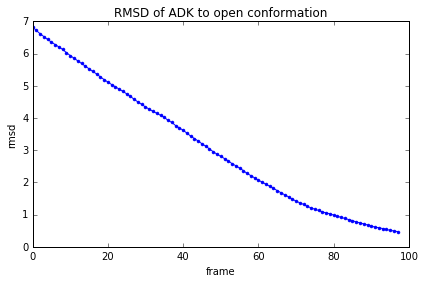

In [19]:
f, ax = plt.subplots()

ax.plot(rmsd, '.-')
ax.set(xlabel='frame', ylabel='rmsd',
       title='RMSD of ADK to open conformation')
plt.tight_layout()

# Use MDAnalysis algorithm

In [77]:
rmsd = np.zeros((len(trj.trajectory), 2))

with mda.Writer('rms-alignment.dcd', trj.atoms.n_atoms, 
                start=trj.trajectory.start_timestep,
                step=trj.trajectory.skip_timestep,
                dt=trj.trajectory.delta) as w:
    for i, ts in enumerate(trj.trajectory):
        rmsd[i] = mda.analysis.align.alignto(trj, ref, select='backbone')
        w.write(trj)

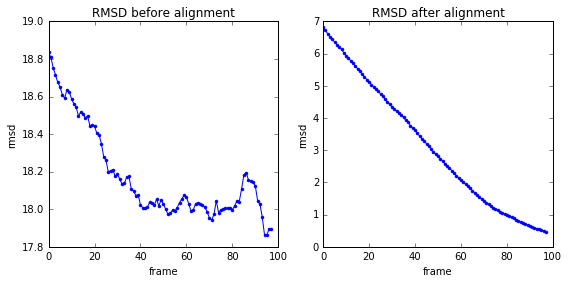

In [78]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(.5))

def _plot(ax, rmsd):
    ax.plot(rmsd, '.-')
    ax.set(xlabel='frame', ylabel='rmsd')
    
_plot(ax1, rmsd[:, 0])
ax1.set(title='RMSD before alignment')

_plot(ax2, rmsd[:, 1])
ax2.set(title='RMSD after alignment')

plt.tight_layout()